In [1]:
import pandas as pd
import micom
import matplotlib.pyplot as plt
import seaborn as sns
# import pyreadr
import micom.measures
import numpy as np 
from plotnine import *
import scipy.stats

%matplotlib inline

## Get Metadata

In [2]:
metadata = pd.read_table('../Hiseq_metagenomic_202_190916 metadata_conditions.txt')
metadata = metadata.drop(metadata.index[[0,83,84]])
baseline = metadata[metadata['time_point']=='00_Baseline']['Name']
endpoint = metadata[metadata['time_point']=='12_Week']['Name']
treatment = metadata[metadata['treatment_group']=='wbf11']['Name']
placebo = metadata[metadata['treatment_group']=='placebo']['Name']
subject_dict = metadata.set_index('Name')['subject_id'].to_dict()
treatment_dict = metadata.set_index('Name')['treatment_group'].to_dict()
metadata[(metadata['Name'].isin(treatment))&(metadata['Name'].isin(endpoint))]
metadata.treatment_group.unique()
metadata

,Name,subject_id,time_point,treatment_group
1,C0223873,SS_65,00_Baseline,wbf11
2,C0253061,SS_60,00_Baseline,wbf11
3,C0227725,SS_46,00_Baseline,wbf11
4,C0264833,SS_31,12_Week,placebo
5,C0252289,SS_67,00_Baseline,wbf11
...,...,...,...,...
78,C0228492,SS_118,12_Week,placebo
79,C1064093,SS_102,12_Week,wbf11
80,C0231040,SS_76,12_Week,placebo
81,C0263808,SS_71,12_Week,placebo


## Get Medium

In [19]:
eu_medium = micom.qiime_formats.load_qiime_medium('/proj/gibbons/refs/micom_media/media/average_european_agora2.qza')
eu_medium_wbf11 = eu_medium.copy()
eu_medium_wbf11.loc['EX_inulin_m', 'flux'] = 4
# eu_medium_wbf11.loc['EX_inulin_m', 'flux'] = 2

## Grow Models

In [20]:
manifest_probiotic = pd.read_csv('../MCMM_mixedAMUC_5%_001/manifest.csv')
growth_probiotic= micom.workflows.grow(manifest_probiotic, 
                              model_folder = '../MCMM_mixedAMUC_5%_001/',
                              medium = eu_medium_wbf11,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)

growth_noPrebiotic = micom.workflows.grow(manifest_probiotic, 
                              model_folder = '../MCMM_mixedAMUC_5%_001/',
                              medium = eu_medium,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)

manifest_baseline = pd.read_csv('../MCMM_mixedAMUC_noPro_001/manifest.csv')
growth_baseline = micom.workflows.grow(manifest_baseline, 
                              model_folder = '../MCMM_mixedAMUC_noPro_001/',
                              medium = eu_medium,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)
growth_noProbiotic =  micom.workflows.grow(manifest_baseline, 
                              model_folder = '../MCMM_mixedAMUC_noPro_001/',
                              medium = eu_medium_wbf11,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)

manifest_placebo = pd.read_csv('../MCMM_mixedAMUC_placebo_001/manifest.csv')
growth_placebo = micom.workflows.grow(manifest_placebo, 
                              model_folder = '../MCMM_mixedAMUC_placebo_001/',
                              medium = eu_medium,
                              tradeoff = 0.99, 
                              strategy = 'none',                                    
                              threads = 20)


Output()

Output()

Output()

Output()

Output()

## Calculate SCFAs

In [35]:
production_baseline= micom.measures.production_rates(growth_baseline) # Calculate production rates 
production_baseline['timepoint'] = 'No Treatment'
production_noPrebiotic = micom.measures.production_rates(growth_noPrebiotic)
production_noPrebiotic['timepoint'] = 'WBF-011, no Inulin'
production_probiotic = micom.measures.production_rates(growth_probiotic)
production_probiotic['timepoint'] = 'WBF-011 + Inulin'
production_noProbiotic = micom.measures.production_rates(growth_noProbiotic)
production_noProbiotic['timepoint'] = 'Inulin, no WBF-011'
production_placebo = micom.measures.production_rates(growth_placebo)
production_placebo['timepoint'] = 'Placebo'

production = pd.concat([production_baseline, production_probiotic, production_placebo, production_noPrebiotic, production_noProbiotic], axis = 0) # Concatenate to single frame

production['subject_id'] = production['sample_id'].map(subject_dict).str.split('_').str[1] # Map Subject IDs

production_but = production[production['metabolite'] == 'but[e]'] # Isolate SCFAs
production_ppa = production[production['metabolite'] == 'ppa[e]']

production_but.sort_values(by = 'timepoint')

,sample_id,metabolite,flux,name,molecular_weight,C_number,N_number,bigg.metabolite,biocyc,chebi,...,lipidmaps,metanetx.chemical,pubchem.compound,reactome,sbo,seed.compound,smiles,reaction,timepoint,subject_id
4537,C0265088,but[e],11.454155,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"Inulin, no WBF-011",18
233,C0219781,but[e],16.403565,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"Inulin, no WBF-011",70
406,C0223873,but[e],31.833839,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"Inulin, no WBF-011",65
582,C0224389,but[e],23.700290,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"Inulin, no WBF-011",49
753,C0224393,but[e],9.964165,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"Inulin, no WBF-011",102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,C0255877,but[e],4.058035,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"WBF-011, no Inulin",39
4074,C0255885,but[e],6.803707,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"WBF-011, no Inulin",1
4252,C0264324,but[e],6.429694,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"WBF-011, no Inulin",108
4615,C0265088,but[e],7.106700,butyrate,87.09718,4,0,NaN,NaN,NaN,...,NaN,NaN,264,NaN,NaN,NaN,NaN,EX_but(e),"WBF-011, no Inulin",18


# Plot Results

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 12 x 8 in image.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/butyratePrediction.svg


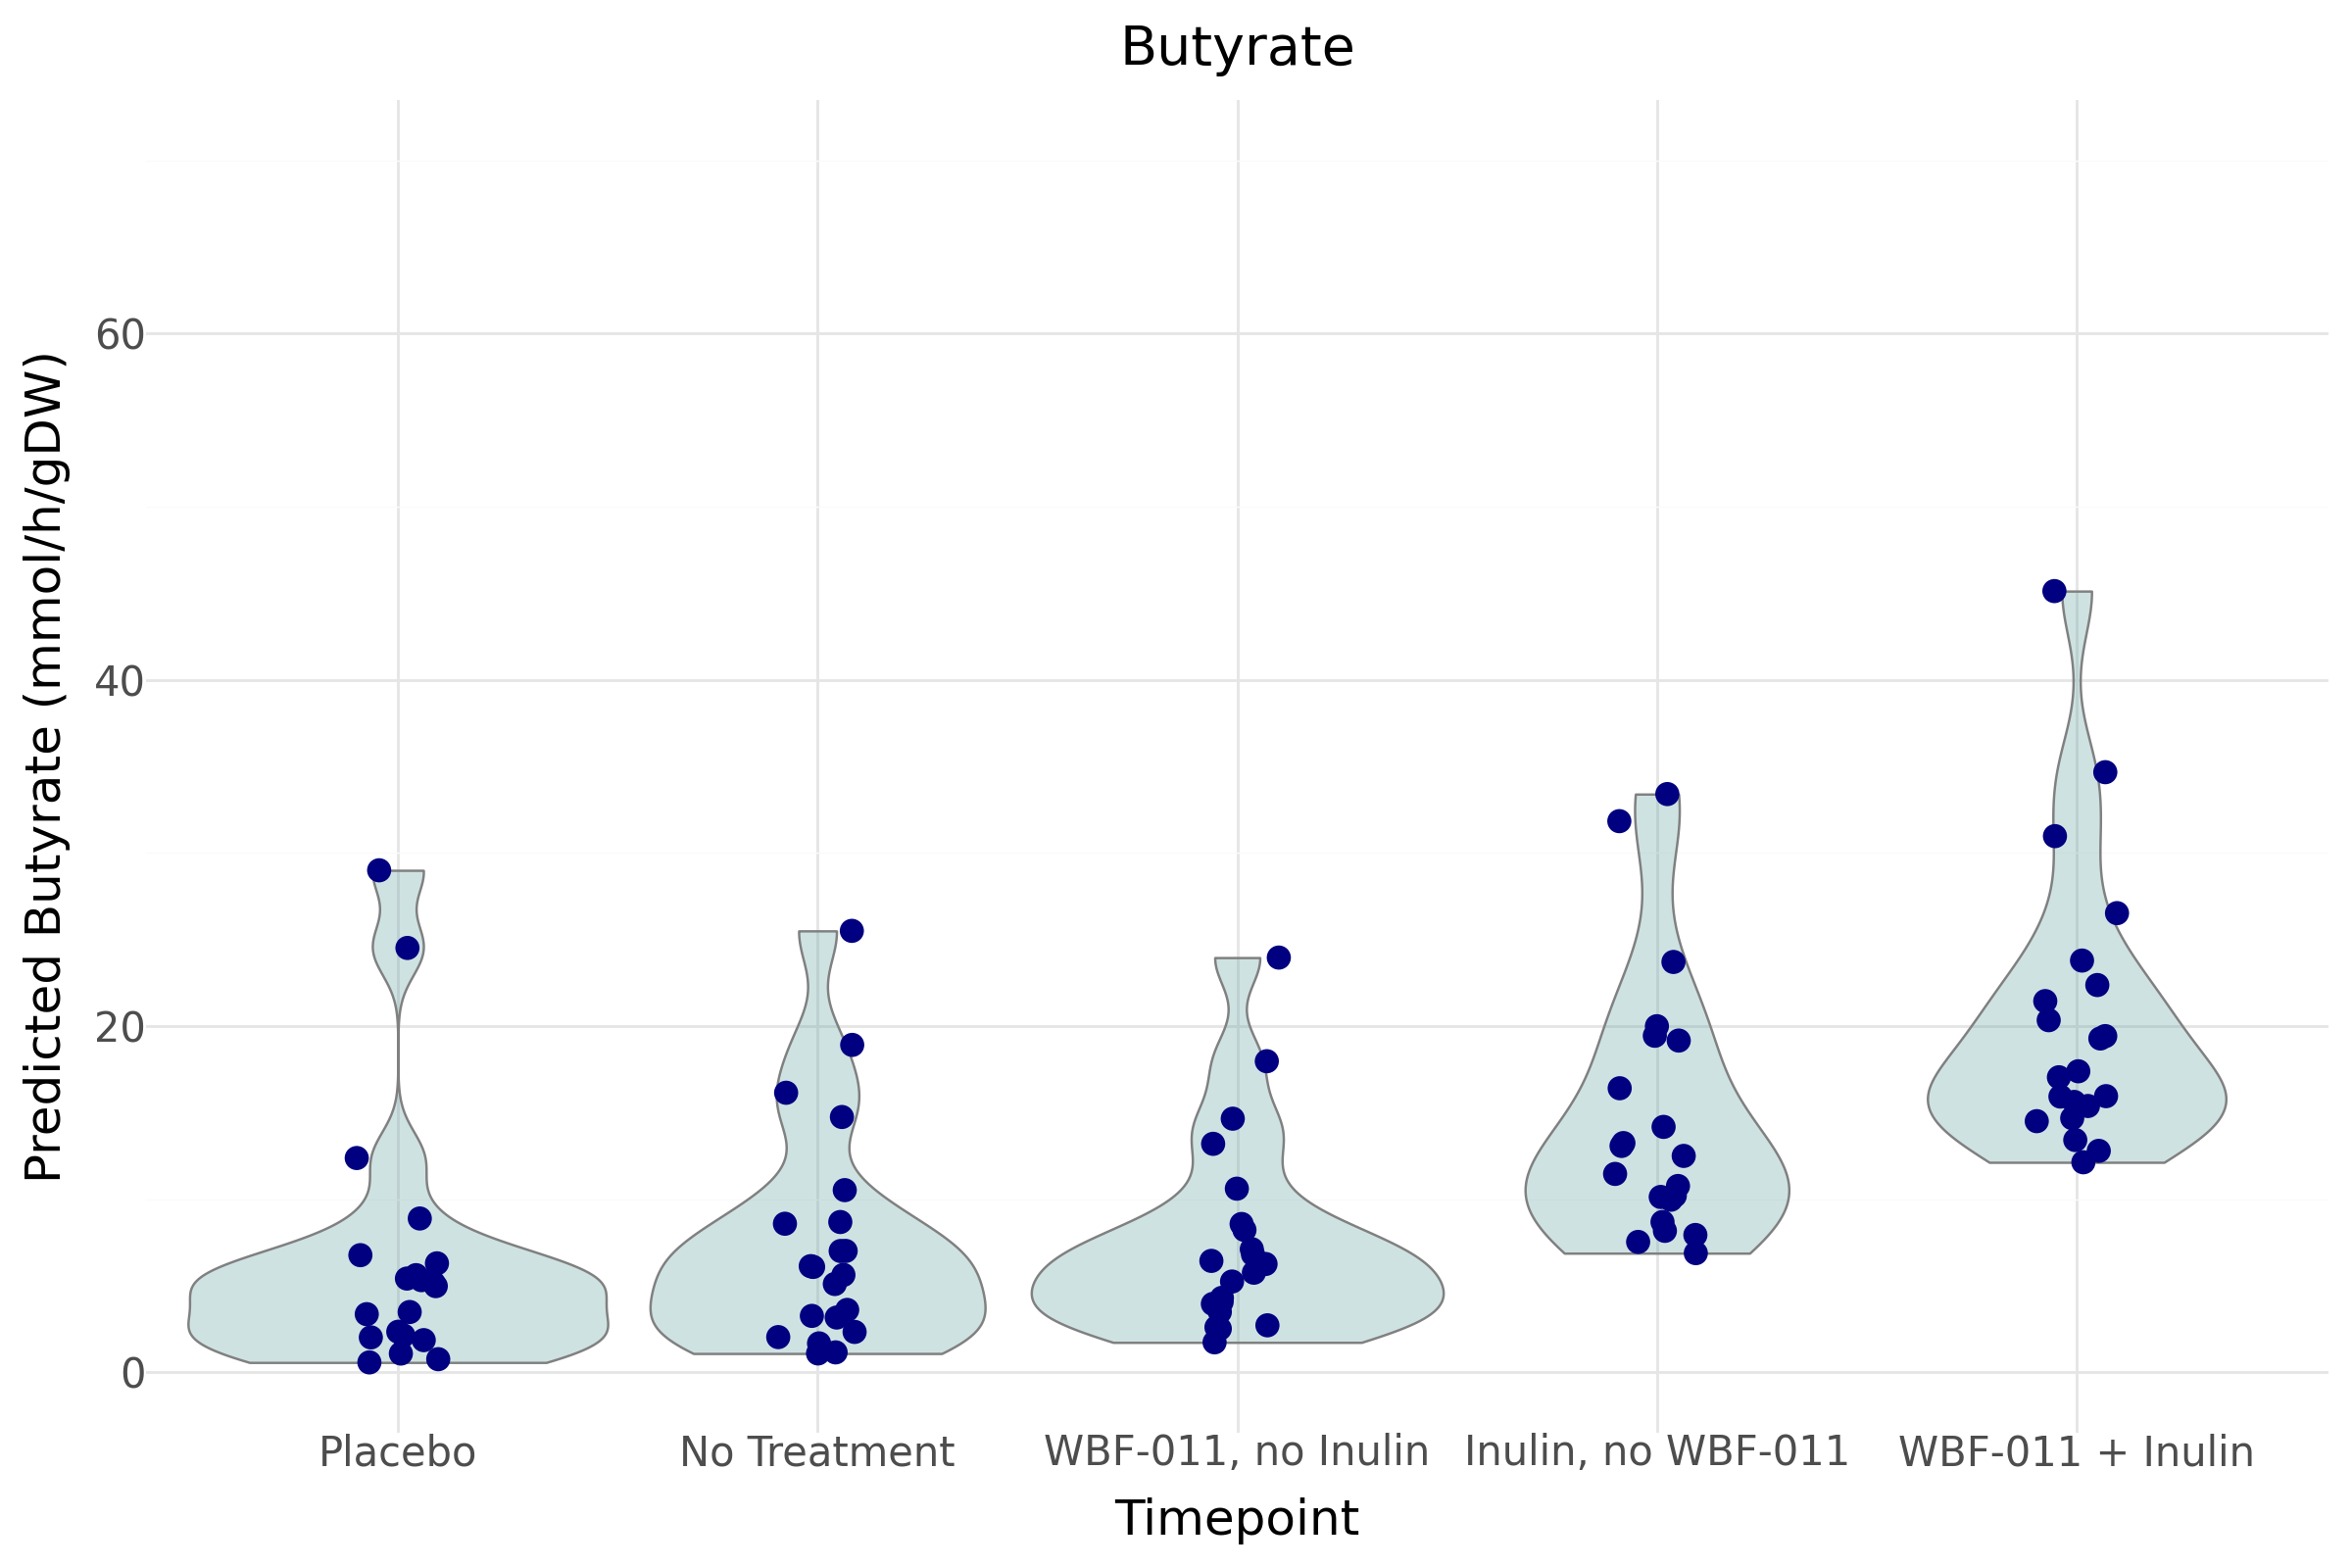

In [39]:
but_plot = (ggplot(production_but, aes(x = 'timepoint', y = 'flux'))
            +geom_violin(color = 'gray', fill = 'cadetblue', alpha = 0.3, width = 1)
            +geom_jitter(color = 'navy', width = .1, size = 4)
            +labs(x = 'Timepoint', y = 'Predicted Butyrate (mmol/h/gDW)',  title = 'Butyrate')
            +scale_x_discrete(limits = ['Placebo','No Treatment','WBF-011, no Inulin','Inulin, no WBF-011','WBF-011 + Inulin'])
            +ylim(0, 70)
            +theme_minimal()
            +theme(figure_size=(12, 8),  axis_title=element_text(size=18),
        axis_text=element_text(size=15),
        plot_title=element_text(size=20))
            
           )
ggsave(but_plot, '../figures/butyratePrediction.svg',dpi =200)
but_plot

In [37]:
scipy.stats.mannwhitneyu(production_but[production_but['timepoint'] == 'Inulin, no WBF-011']['flux'],
production_but[production_but['timepoint'] == 'WBF-011 + Inulin']['flux'])

# production_but[production_but['timepoint'] == 'WBF-011 + Inulin']['flux'].mean()

MannwhitneyuResult(statistic=108.0, pvalue=0.004840772120689793)

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 12 x 8 in image.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/propionatePrediction.svg


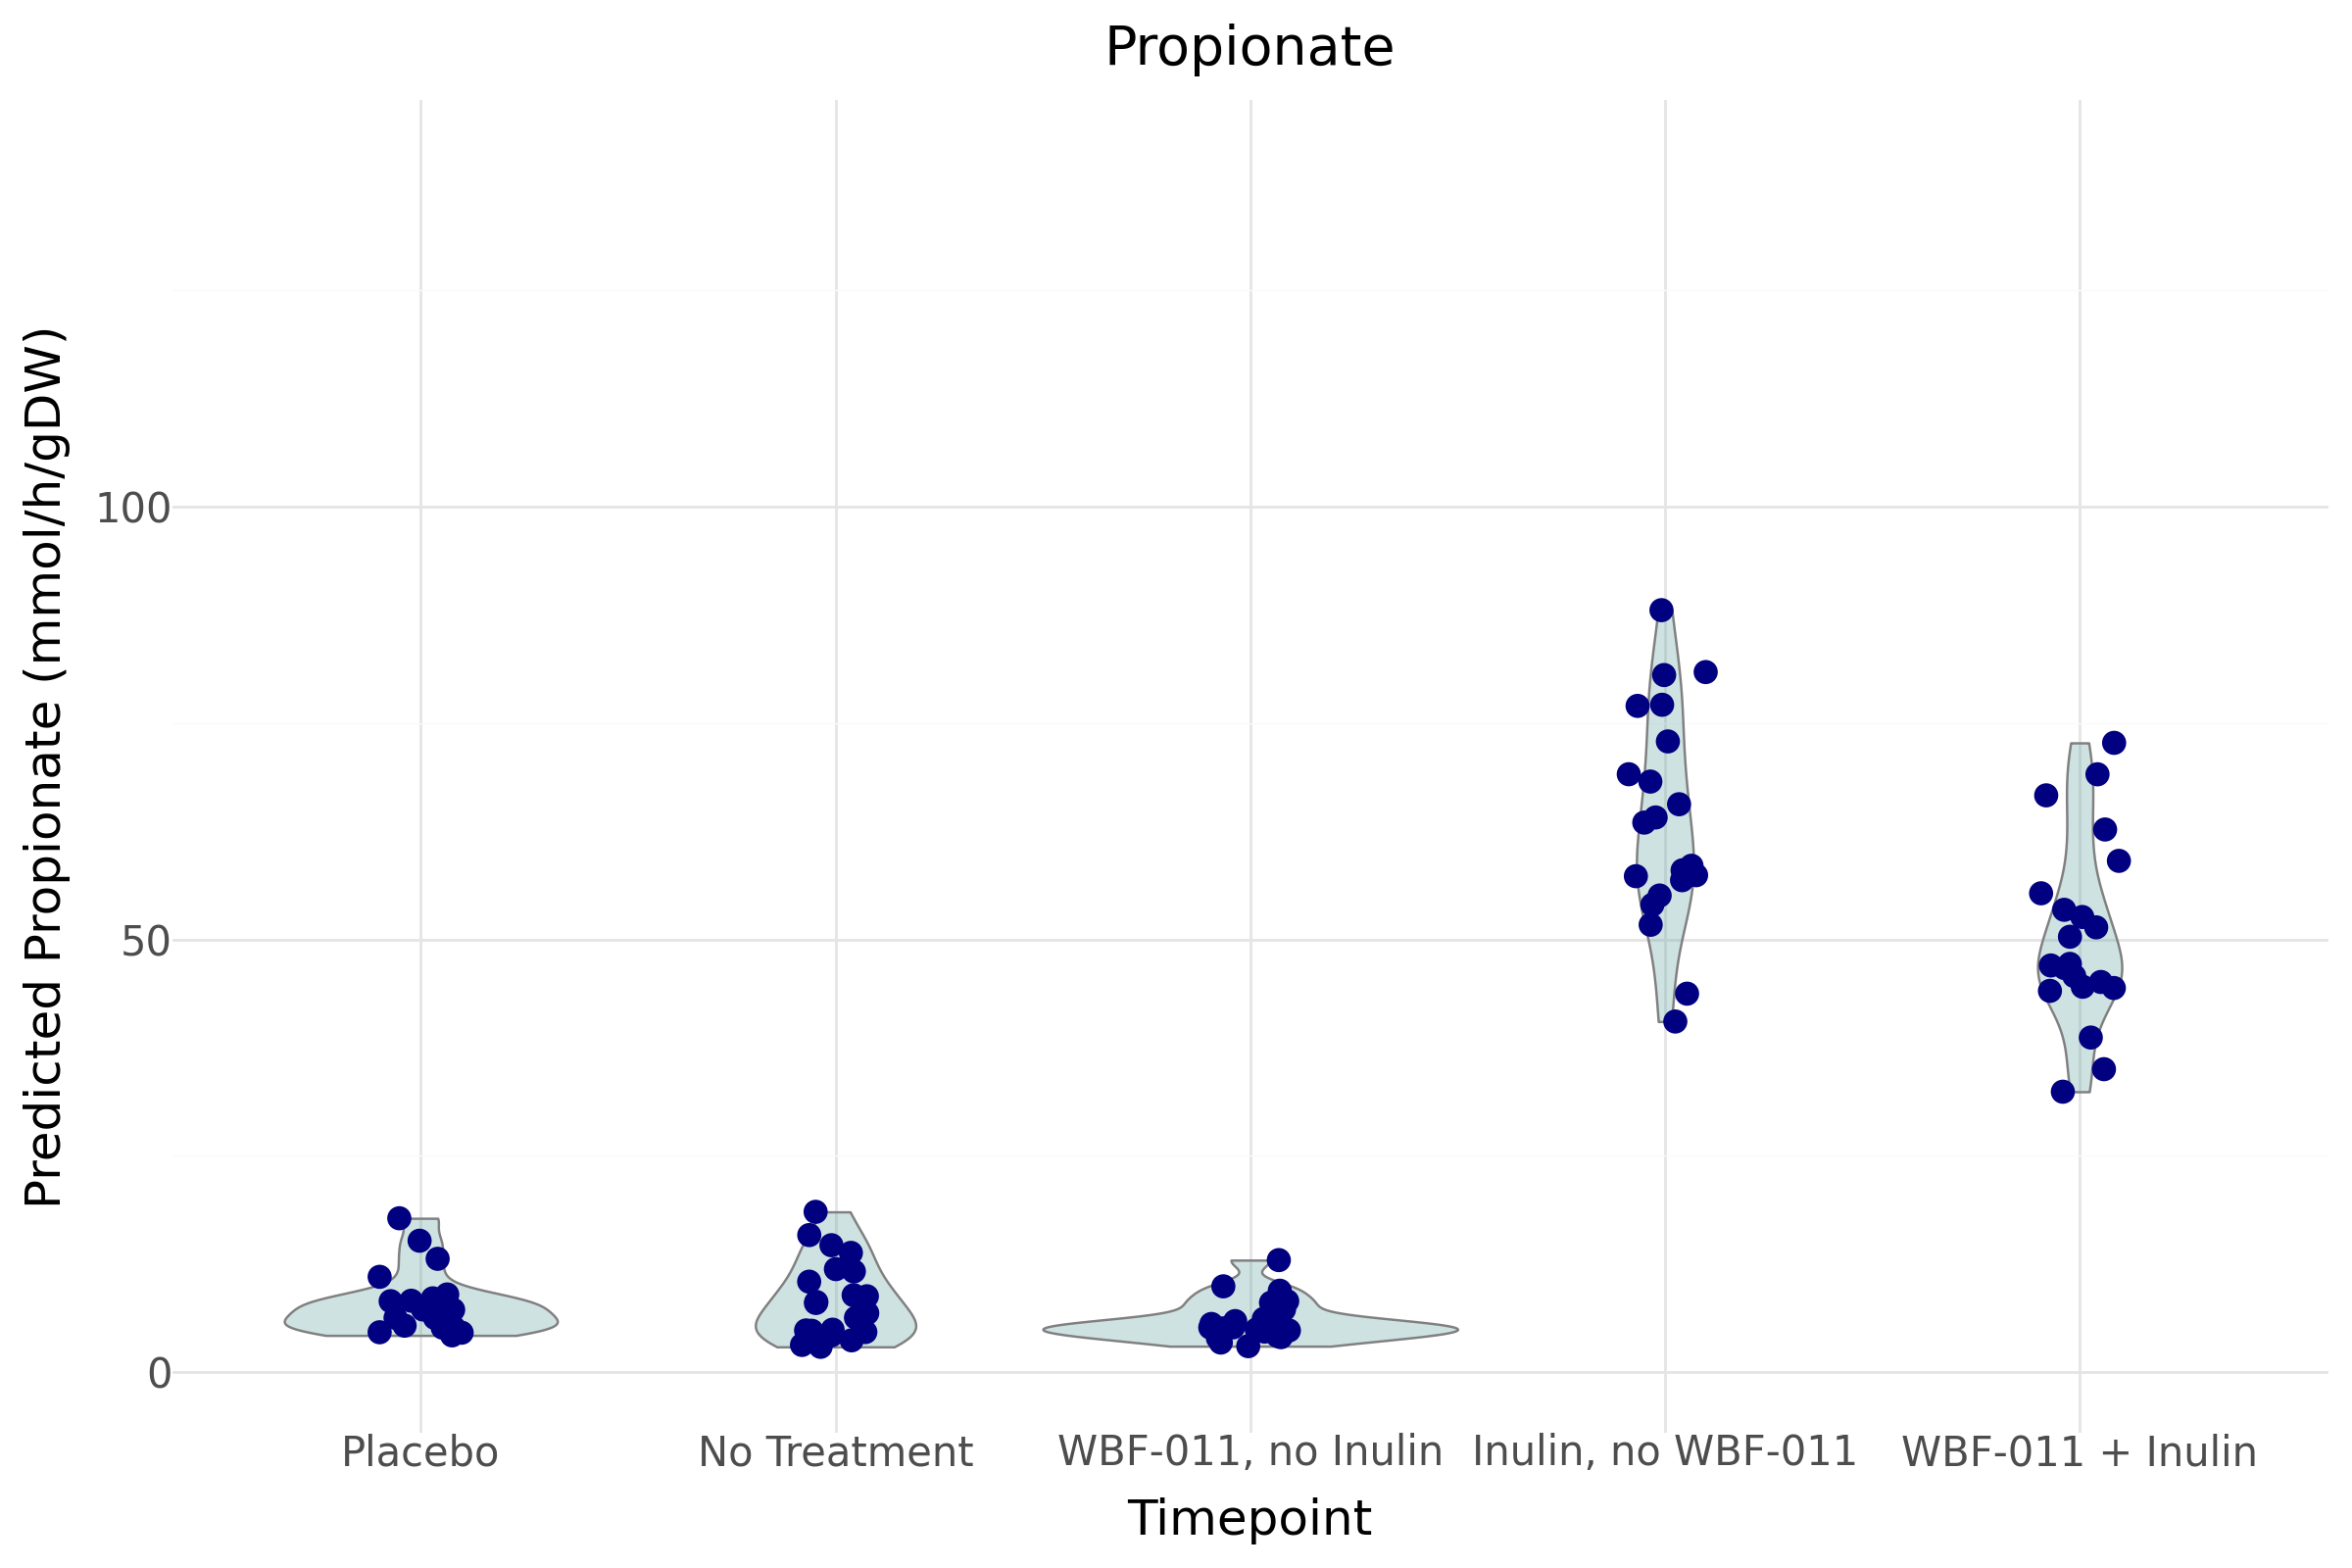

In [44]:
ppa_plot = (ggplot(production_ppa, aes(x = 'timepoint', y = 'flux'))
          +geom_violin(color = 'gray', fill = 'cadetblue', alpha = 0.3, width = 1)
            +geom_jitter(color = 'navy', width = .1, size = 4)
            +labs(x = 'Timepoint', y = 'Predicted Propionate (mmol/h/gDW)',  title = 'Propionate')
            +scale_x_discrete(limits = ['Placebo','No Treatment','WBF-011, no Inulin','Inulin, no WBF-011','WBF-011 + Inulin'])
            +ylim(0, 140)
            +theme_minimal()
            +theme(figure_size=(12, 8),  axis_title=element_text(size=18),
        axis_text=element_text(size=15),
        plot_title=element_text(size=20))
            
           )
ggsave(ppa_plot, '../figures/propionatePrediction.svg',dpi =200)
ppa_plot

In [ ]:
scipy.stats.mannwhitneyu(production_but[production_but['timepoint'] == 'WBF-011 + Inulin']['flux'],
production_but[production_but['timepoint'] == 'Inulin, no WBF-011']['flux'])

## Pivot SCFAs 

In [ ]:
production = pd.concat([production_baseline, production_probiotic], axis = 0) # Concatenate to single frame

production['subject_id'] = production['sample_id'].map(subject_dict).str.split('_').str[1] # Map Subject IDs

production_but = production[production['metabolite'] == 'but[e]'] # Isolate SCFAs
production_ppa = production[production['metabolite'] == 'ppa[e]']

but_pvt = pd.pivot_table(production_but, # Build pivot table for butyrate, propionate
                         index = 'subject_id',
                         columns = 'timepoint',
                         values = 'flux').rename(columns = {'No Treatment':'baseline_but',
                                                            'WBF-011 + Inulin':'endpoint_but'})
                                                            
ppa_pvt = pd.pivot_table(production_ppa, 
                         index = 'subject_id',
                         columns = 'timepoint',
                         values = 'flux').rename(columns = {'No Treatment':'baseline_ppa',
                                                            'WBF-011 + Inulin':'endpoint_ppa'})
                                                            
scfas_pvt = pd.concat([but_pvt, ppa_pvt], axis = 1) # Concatenate pivot tables
scfas_pvt['endpoint_tot'] = scfas_pvt['endpoint_but']+scfas_pvt['endpoint_ppa']
scfas_pvt['baseline_tot'] = scfas_pvt['baseline_but']+scfas_pvt['baseline_ppa']
scfas_pvt['delta_but'] = scfas_pvt['endpoint_but']-scfas_pvt['baseline_but']
scfas_pvt['delta_ppa'] = scfas_pvt['endpoint_ppa']-scfas_pvt['baseline_ppa']
scfas_pvt['delta_tot'] = scfas_pvt['endpoint_tot']-scfas_pvt['baseline_tot']
scfas_pvt

## Compare with Probiotic Growth Rates

In [ ]:
probiotic_rates = growth_probiotic.growth_rates.reset_index()
probiotic_rates_pvt = pd.pivot_table(probiotic_rates, 
                                    index = 'sample_id', 
                                    columns = 'compartments',
                                    values = 'growth_rate')
probiotic_rates_pvt = probiotic_rates_pvt[['Akkermansia_muciniphila','Bifidobacterium_longum','Anaerobutyricum_hallii','Clostridium_butyricum', 'Clostridium_beijerinckii']]
probiotic_rates_pvt['subject_id'] = probiotic_rates_pvt.index.map(subject_dict).str.split('_').str[1]
probiotic_rates_pvt.set_index('subject_id', inplace = True, drop = True)
probiotic_rates_pvt = np.log10(probiotic_rates_pvt+0.0000000000001)

## Merge with CRP

In [ ]:
CRP = pd.read_excel('/proj/gibbons/2024_Pendulum_trial/tabCRPMeasures.xlsx')
CRP.rename(columns = {'SUBJECT_ID':'subject_id',
                      'CRP_V1':'baselineCRP',
                      'CRP_V3':'midpointCRP',
                      'CRP_V7':'endpointCRP'},
           inplace = True)
CRP['deltaCRP'] = CRP['endpointCRP']-CRP['baselineCRP']
CRP = CRP[['subject_id','baselineCRP','endpointCRP','deltaCRP']]
CRP.set_index('subject_id', inplace = True)
CRP.index = CRP.index.astype('str')
CRP = CRP[CRP.index.isin(probiotic_rates_pvt.index)]
CRP

## Merge with SCFAs

In [ ]:
metabolon = pyreadr.read_r('/proj/gibbons/2024_Pendulum_trial/tabMetabolonScfaEventWide.RDS')[None].set_index('Subject')
metabolon_but = metabolon[(metabolon['BIOCHEMICAL'] == 'Butyric acid')&(metabolon['treatment'] == 'wbf11')]
metabolon_but = metabolon_but[['Baseline','Week12','Week12MinusBaseline','log2Wk12OverBaseline']].rename(columns = {'Baseline':'baselineButyrate',
                                                                                                          'Week12':'week12Butyrate',
                                                                                                          'Week12MinusBaseline':'differenceButyrate',
                                                                                                          'log2Wk12OverBaseline':'log2differenceButyrate'})
metabolon_but

## Merge with Metabolic Endpoints

In [ ]:
glucose = pyreadr.read_r('/proj/gibbons/2024_Pendulum_trial/tabGluCtl.RDS')[None].set_index('Subject')
glucose_WBF11 = glucose.loc[glucose['treatment'] == 'wbf11']

## Regress Measures against Predictions

In [ ]:
comp_df = pd.concat([glucose_WBF11, metabolon_but, CRP, scfas_pvt], axis = 1)
comp_df.fillna(0.0, inplace = True)
glucose = comp_df.columns[1:10]
metabolon = comp_df.columns[10:14]
crp = comp_df.columns[14:17]
predictions = comp_df.columns[17:]

comp_df.reset_index(inplace = True)
regressions = pd.DataFrame()
for measure in crp:
    for prediction in predictions:
        slope, intcpt, r, p, std = scipy.stats.linregress(comp_df[measure], comp_df[prediction])
        res = pd.DataFrame({'measure':[measure], 'prediction':[prediction], 'rvalue':[r], 'pvalue':[p]})
        regressions = pd.concat([regressions, res])
regressions

In [ ]:
butCRP_plot = (ggplot(comp_df, aes(x = 'delta_but', y = 'deltaCRP'))
            +geom_point(size = 3)
            +geom_smooth(method = 'lm')
            +labs(x = 'ΔButyrate (mmol/gDW/h)', y = 'ΔCRP', title = 'Butyrate vs. CRP')
            +theme_minimal()    
            +theme(figure_size=(8, 6))
           )
ggsave(butCRP_plot, '../figures/butCRP.svg', dpi = 300)
butCRP_plot

In [ ]:
butCRP_plot = (ggplot(comp_df, aes(x = 'delta_ppa', y = 'deltaCRP'))
            +geom_point(size = 3)
            +geom_smooth(method = 'lm')
            +labs(x = 'ΔPropionate (mmol/gDW/h)', y = 'ΔCRP', title = 'Propionate vs. CRP')
            +theme_minimal()    
            +theme(figure_size=(8, 6))
           )
ggsave(butCRP_plot, '../figures/ppaCRP.svg', dpi = 300)
butCRP_plot

In [ ]:
df = comp_df[['AUC_INC_GLU_Baseline','AUC_INC_GLU_Week12','baseline_but','endpoint_but']].reset_index()


# Reshape the dataframe using melt
df_long = df.melt(id_vars=['index'], 
                  value_vars=['AUC_INC_GLU_Baseline', 'AUC_INC_GLU_Week12', 'baseline_but', 'endpoint_but'],
                  var_name='Type', 
                  value_name='Value')

# Map the new 'Type' column to distinguish between AUC and butyrate values
df_long['Measurement'] = df_long['Type'].apply(lambda x: 'AUC_INC_GLU' if 'AUC' in x else 'but')
df_long['Timepoint'] = df_long['Type'].apply(lambda x: 'Baseline' if 'Baseline' in x or 'baseline' in x else 'Week12')

# Drop the original 'Type' column to clean up
df_long = df_long.drop(columns=['Type'])

# Pivot so that AUC and butyrate are in separate columns
df_final = df_long.pivot(index=['index', 'Timepoint'], columns='Measurement', values='Value').reset_index()

# Display the result
df_final

ggplot(df_final, aes(x = 'but',y = 'AUC_INC_GLU'))+geom_point(aes(color = 'Timepoint'))+geom_smooth(method = 'lm')

In [ ]:
ggplot(glucose, aes(x = '', y = 'AUC_INC_GLU_Week12'))+geom_boxplot()

In [ ]:
placebo_scfas = production_placebo[(production_placebo['metabolite'] == 'ppa[e]')|(production_placebo['metabolite'] == 'but[e]')]
placebo_scfas = pd.pivot(placebo_scfas, 
                         index = 'sample_id',
                         columns = 'name', 
                         values = 'flux').reset_index(drop = True)
probiotic_scfas = production_probiotic[(production_probiotic['metabolite'] == 'ppa[e]')|(production_probiotic['metabolite'] == 'but[e]')]
probiotic_scfas = pd.pivot(probiotic_scfas, 
                         index = 'sample_id',
                         columns = 'name', 
                         values = 'flux').reset_index(drop = True)
probiotic_scfas

In [ ]:
scipy.stats.mannwhitneyu(probiotic_scfas['Propionate'], placebo_scfas['propionate'])

In [ ]:
comp_df